In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import optuna
import joblib
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error,mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder

# Configuração de logs do Optuna
optuna.logging.set_verbosity(optuna.logging.INFO)


In [16]:
query = """
SELECT
    -- Alvo e Tempo
    ano,
    valor_remuneracao_media,
    
    -- Profissional
    cbo_2002,
    grau_instrucao_apos_2005 AS escolaridade,
    idade,
    sexo,
    raca_cor,
    tempo_emprego, -- Meses no emprego atual
    
    -- Local e Contrato
    sigla_uf,
    id_municipio,
    quantidade_horas_contratadas,
    tipo_vinculo,
    
    -- Empresa
    tamanho_estabelecimento,
    natureza_juridica,
    subsetor_ibge -- ou cnae_2 se quiser mais detalhe
FROM  
    `basedosdados.br_me_rais.microdados_vinculos`

WHERE ANO >=2019
    
    -- Limpeza Básica de Ruído (Salários zerados ou inconsistentes)
    AND valor_remuneracao_media > 0
    
    -- Filtro de Cargos (A Lista "Elite" de Dados + TI + Produto)
    AND (
        -- Família Clássica de TI (Desenvolvedores, Infra, Suporte)
        cbo_2002 LIKE '212%' 
        
        -- Família de Dados e Matemática (Data Science/Analytics)
        OR cbo_2002 LIKE '2112%' -- Estatísticos
        OR cbo_2002 = '211110'   -- Matemático
        OR cbo_2002 = '142335'   -- Analista de Inteligência de Mercado (BI)

        -- Gestão e Liderança Específica de TI
        OR cbo_2002 IN ('123605', '142505', '142515', '142520', '142525', '142530', '142535')

        -- Pesquisa e Ensino Superior
        OR cbo_2002 IN ('203105', '234120')

        -- Operacional Técnico e Suporte
        OR cbo_2002 IN ('317110', '317210')

        -- Design e Produto (UX/UI)
        OR cbo_2002 = '262410'
        
      -- [NOVO] Produto, Negócios e Governança (PO/PM/DPO)
        OR cbo_2002 IN ('142330', '142135', '142355')

        -- [NOVO] Desenvolvimento Web e Multimídia
        OR cbo_2002 IN ('317105', '317120')

        -- [NOVO] Engenharia e Técnica de Redes/Telecom (SRE/Infra)
        OR cbo_2002 IN ('214350', '313310', '313305')

        -- [NOVO] Inteligência de Dados Financeiros/Risco
        OR cbo_2002 IN ('142130')  
        
    )
"""

#### gcloud auth application-default login para se autenticar no bigquery

In [17]:
arquivo_local = 'dados_rais_brutos.parquet'

if os.path.exists(arquivo_local):
    print("Carregando dados do arquivo local...")
    df_pand = pd.read_parquet(arquivo_local)
else:
    print("Arquivo local não encontrado. Iniciando download do BigQuery...")
    
    df_pand = pd.read_gbq(
        query,
        project_id='rais-398715', # Certifique-se que este ID é do SEU projeto no Google Cloud
        dialect='standard',
        progress_bar_type='tqdm' # <--- MOSTRA BARRA DE PROGRESSO
    )
    
    print(f"Download concluído! Salvando {len(df_pand)} linhas em Parquet...")
    df_pand.to_parquet(arquivo_local, index=False)
    print("Salvo com sucesso!")

print(f"Total de linhas carregadas: {len(df_pand)}")

Carregando dados do arquivo local...
Total de linhas carregadas: 7460185


In [18]:
df_pand.head()  # Mostrar as primeiras linhas para verificação

,ano,valor_remuneracao_media,cbo_2002,escolaridade,idade,sexo,raca_cor,tempo_emprego,sigla_uf,id_municipio,quantidade_horas_contratadas,tipo_vinculo,tamanho_estabelecimento,natureza_juridica,subsetor_ibge
0,2024,1573.83,142335,7,24,2,8,10.7,RJ,3301504,44,10,4,2062,11
1,2023,1428.38,313310,7,45,1,8,1.5,RJ,3301603,44,60,4,2062,15
2,2023,1823.07,313310,7,23,1,9,2.9,RJ,3301603,44,10,3,2062,15
3,2023,1460.12,313310,7,21,1,2,0.7,RJ,3301603,44,60,4,2062,15
4,2024,2639.92,317210,1,25,2,2,16.3,RJ,3301504,44,10,6,2062,16


In [19]:

# ==============================================================================
# 1. CARREGAMENTO E CRIAÇÃO DO MAPA DE CBO
# ==============================================================================
print("1. Carregando dicionários e dados...")

# --- A. CARREGAR O DICIONÁRIO DE CBO (NOVA ETAPA) ---
# Lê o arquivo CSV externo que contém "CODIGO" e "TITULO"
try:
    # encoding='latin-1' é padrão para arquivos do governo brasileiro (CBO)
    df_cbo_ref = pd.read_csv('dados/CBO2002 - Ocupacao.csv', sep=';', encoding='latin-1', dtype={'CODIGO': str})
    
    # Cria o mapa { '212405': 'Analista de desenvolvimento de sistemas' }
    cbo_map = df_cbo_ref.set_index('CODIGO')['TITULO'].to_dict()
    print(f"   > Dicionário de CBO carregado com {len(cbo_map)} ocupações.")
    
except FileNotFoundError:
    print("AVISO: Arquivo 'CBO2002 - Ocupacao.csv' não encontrado. Os nomes dos cargos não aparecerão.")
    cbo_map = {}



1. Carregando dicionários e dados...
   > Dicionário de CBO carregado com 2694 ocupações.


In [20]:
df_cbo_ref.head()

,CODIGO,TITULO
0,010105,Oficial general da aeronáutica
1,010110,Oficial general do exército
2,010115,Oficial general da marinha
3,010205,Oficial da aeronáutica
4,010210,Oficial do exército


In [21]:
# ==============================================================================
# 2. PREPARAÇÃO DE DADOS (V3.2 - CORRIGIDA E OTIMIZADA)
# ==============================================================================
print("\n2. Preparando dados com Engenharia de Features Expandida...")

df_ml = df_pand.copy()

# 1. LIMPEZA DE RUÍDO
df_ml = df_ml[df_ml['valor_remuneracao_media'] >= 1300] 
df_ml = df_ml[df_ml['valor_remuneracao_media'] <= 50000]

# 2. TRATAMENTO DE NULOS E CONVERSÃO PARA STRING (TEXTO)
# Importante: Convertemos TUDO para string ANTES de criar os mapas.
# Isso garante que o dicionário salvo no .pkl tenha chaves de texto ("12345") 
# e não números (12345), evitando erros no app.py.

colunas_para_converter = [
    'tamanho_estabelecimento', 
    'subsetor_ibge', 
    'cbo_2002', 
    'escolaridade', 
    'sigla_uf'
]

for col in colunas_para_converter:
    if col in df_ml.columns:
        # Preenche nulos com 'Ignorado' e força conversão para string
        df_ml[col] = df_ml[col].fillna('Ignorado').astype(str)
        # Remove .0 que as vezes aparece em conversão de float (ex: "9.0" vira "9")
        df_ml[col] = df_ml[col].apply(lambda x: x.split('.')[0] if '.' in x else x)
    else:
        print(f"⚠️ Aviso: Coluna '{col}' não encontrada. Criando com 'Ignorado'.")
        df_ml[col] = 'Ignorado'

# 3. DEFINIÇÃO DO ALVO
target = 'valor_remuneracao_media'

# 4. TARGET ENCODING (Cálculo das Médias por Categoria)
print("   > Calculando médias salariais por categoria...")

# Calcula o dicionário de médias (AGORA SIM, com chaves em string)
mapa_medias = {
    'cbo':   df_ml.groupby('cbo_2002')[target].median().to_dict(),
    'uf':    df_ml.groupby('sigla_uf')[target].median().to_dict(),
    'esc':   df_ml.groupby('escolaridade')[target].median().to_dict(),
    'tam':   df_ml.groupby('tamanho_estabelecimento')[target].median().to_dict(),
    'setor': df_ml.groupby('subsetor_ibge')[target].median().to_dict()
}

# Valor global para fallback (caso chegue algo novo)
media_global = df_ml[target].median()

# Aplica o mapeamento (Cria as colunas numéricas que o modelo vai ler)
df_ml['cbo_valor']   = df_ml['cbo_2002'].map(mapa_medias['cbo']).fillna(media_global)
df_ml['uf_valor']    = df_ml['sigla_uf'].map(mapa_medias['uf']).fillna(media_global)
df_ml['esc_valor']   = df_ml['escolaridade'].map(mapa_medias['esc']).fillna(media_global)
df_ml['tam_valor']   = df_ml['tamanho_estabelecimento'].map(mapa_medias['tam']).fillna(media_global)
df_ml['setor_valor'] = df_ml['subsetor_ibge'].map(mapa_medias['setor']).fillna(media_global)

# 5. LABEL ENCODING (Para Sexo e Raça)
encoders = {}
for col in ['sexo', 'raca_cor']:
    le = LabelEncoder()
    # Garante que é string antes de treinar o encoder
    df_ml[col] = df_ml[col].astype(str)
    # Cria a coluna com sufixo _valor ou sobrescreve (no seu caso original você sobrescrevia)
    # Aqui vamos manter o padrão do seu código original de sobrescrever ou criar nova se preferir.
    # Vou manter sobrescrevendo para não quebrar o resto do seu código:
    df_ml[col] = le.fit_transform(df_ml[col])
    encoders[col] = le # Salva o encoder (se precisar inverter depois)
    
    # Para salvar no pickle com o nome certo que o app.py espera ('raca_cor_valor'?), 
    # vou adicionar essa referência no dicionário de encoders:
    if col == 'raca_cor':
        encoders['raca_cor_valor'] = le

# 6. LISTA FINAL DE FEATURES (X)
features = [
    'cbo_valor', 
    'idade', 
    'esc_valor', 
    'uf_valor', 
    'tam_valor',   # Tamanho da Empresa
    'setor_valor', # Subsetor IBGE
    'sexo', 
    'raca_cor', 
    'ano'
]

X = df_ml[features]

# Aplica LOG no alvo
y_log = np.log1p(df_ml[target])

# Divisão Treino/Teste
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

print(f"   > Dados prontos com {len(features)} variáveis. Treino: {X_train.shape[0]} linhas.")


2. Preparando dados com Engenharia de Features Expandida...
   > Calculando médias salariais por categoria...
   > Dados prontos com 9 variáveis. Treino: 5706434 linhas.


In [22]:

# ==============================================================================
# 3. OTIMIZAÇÃO COM OPTUNA (MODO TURBO)
# ==============================================================================
print("\n3. Iniciando busca pelos melhores parâmetros com Optuna...")

def objective_lgbm(trial):
    params = {
        # --- ATIVAÇÃO DA GPU ---
        'device': 'gpu',           # Instrui o LightGBM a usar a placa de vídeo
        'gpu_platform_id': 0,      # ID da plataforma (geralmente 0)
        'gpu_device_id': 0,        # ID da placa (geralmente 0 se tiver só uma)
        
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'n_jobs': -1,
        'random_state': 42,
        
        # Espaço de busca otimizado para LightGBM
        'n_estimators': trial.suggest_int('n_estimators', 500, 2500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    model = lgb.LGBMRegressor(**params)
    
    # Validação cruzada (3 dobras)
    scores = cross_val_score(model, X_train, y_train_log, cv=3, scoring='neg_mean_absolute_error')
    return -scores.mean()

# Executa o estudo
study = optuna.create_study(direction='minimize')
study.optimize(objective_lgbm, n_trials=10, show_progress_bar=True) 

print(f"\n   > Melhores parâmetros: {study.best_params}")


[I 2025-12-30 12:02:21,917] A new study created in memory with name: no-name-e7582a91-5982-4452-a5e3-fc7ce31d3b08



3. Iniciando busca pelos melhores parâmetros com Optuna...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-30 12:08:20,404] Trial 0 finished with value: 0.366819165701191 and parameters: {'n_estimators': 2089, 'learning_rate': 0.09593082977766637, 'num_leaves': 81, 'max_depth': 15, 'subsample': 0.7425398720904881, 'colsample_bytree': 0.6403173995786096, 'reg_alpha': 0.0003260575644970656, 'reg_lambda': 0.00019542257143434686}. Best is trial 0 with value: 0.366819165701191.
[I 2025-12-30 12:13:49,236] Trial 1 finished with value: 0.3775012133005493 and parameters: {'n_estimators': 1796, 'learning_rate': 0.01856979316389015, 'num_leaves': 65, 'max_depth': 9, 'subsample': 0.9064414672232068, 'colsample_bytree': 0.7056583126105406, 'reg_alpha': 0.15569571903950113, 'reg_lambda': 0.11462838485203938}. Best is trial 0 with value: 0.366819165701191.
[I 2025-12-30 12:15:39,165] Trial 2 finished with value: 0.38283632361742553 and parameters: {'n_estimators': 1001, 'learning_rate': 0.1027090490978631, 'num_leaves': 92, 'max_depth': 4, 'subsample': 0.7689167089651082, 'colsample_bytree': 0


4. Treinando modelo definitivo...

=== RESULTADOS FINAIS ===
R² (Explicação): 48.31%
Erro Médio (MAE): R$ 2444.68
Raiz do Erro Quadrático (RMSE): R$ 4239.88
Erro Percentual Médio (MAPE): 39.13%


<Figure size 1000x600 with 0 Axes>

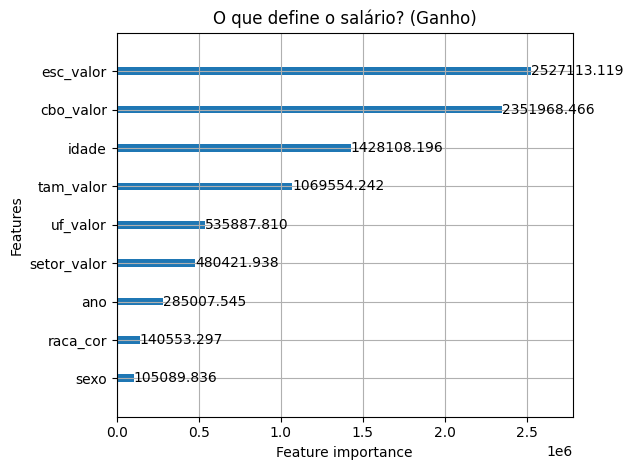

In [26]:

# ==============================================================================
# 4. TREINAMENTO FINAL E AVALIAÇÃO
# ==============================================================================
print("\n4. Treinando modelo definitivo...")

best_params = study.best_params
best_params['n_jobs'] = -1
best_params['random_state'] = 42
best_params['verbose'] = -1

model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train_log)

# Previsão e Reversão
y_pred_log = model.predict(X_test)
y_pred_reais = np.expm1(y_pred_log) # Reverter Log -> Reais
y_test_reais = np.expm1(y_test_log)

# Métricas
mae = mean_absolute_error(y_test_reais, y_pred_reais)
rmse = np.sqrt(mean_squared_error(y_test_reais, y_pred_reais))
mape = mean_absolute_percentage_error(y_test_reais, y_pred_reais)
r2 = r2_score(y_test_reais, y_pred_reais)

print(f"\n=== RESULTADOS FINAIS ===")
print(f"R² (Explicação): {r2:.2%}")
print(f"Erro Médio (MAE): R$ {mae:.2f}")
print(f"Raiz do Erro Quadrático (RMSE): R$ {rmse:.2f}")
print(f"Erro Percentual Médio (MAPE): {mape:.2%}")

# Gráfico de Importância
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=10, importance_type='gain', title='O que define o salário? (Ganho)')
plt.tight_layout()
plt.show()


In [28]:
# ==============================================================================
# 5. CALCULADORA DE SALÁRIO (ATUALIZADA COM SETOR E TAMANHO)
# ==============================================================================
def prever_salario(cbo, idade, escolaridade, uf, sexo, raca, tamanho_empresa, setor_ibge, ano=2024):
    try:
        # 1. Busca o Nome do Cargo no Mapa Externo
        cbo_str = str(cbo)
        nome_cargo = cbo_map.get(cbo_str, f"Cargo {cbo_str} (Nome não encontrado)")

        # 2. Target Encoding (Busca a média histórica nos dicionários)
        # Se não encontrar o valor exato, usa a média_global como segurança
        val_cbo = mapa_medias['cbo'].get(cbo_str, media_global)
        val_esc = mapa_medias['esc'].get(str(escolaridade), media_global)
        val_uf  = mapa_medias['uf'].get(str(uf), media_global)
        
        # Novos campos (Tamanho e Setor)
        val_tam = mapa_medias['tam'].get(str(tamanho_empresa), media_global)
        val_setor = mapa_medias['setor'].get(str(setor_ibge), media_global)
        
        # 3. Label Encoding (Sexo e Raça)
        try:
            val_sexo = encoders['sexo'].transform([str(sexo)])[0]
            val_raca = encoders['raca_cor_valor'].transform([str(raca)])[0]
        except:
            # Fallback simples se a categoria não existir (ex: digitou errado)
            val_sexo, val_raca = 0, 0 

        # 4. DataFrame para o Modelo
        # A ordem das colunas DEVE ser exatamente a mesma usada no treino 'features'
        dados = pd.DataFrame({
            'cbo_valor': [val_cbo],
            'idade': [idade],
            'esc_valor': [val_esc],
            'uf_valor': [val_uf],
            'tam_valor': [val_tam],       # <--- Novo
            'setor_valor': [val_setor],   # <--- Novo
            'sexo': [val_sexo],
            'raca_cor_valor': [val_raca], # Corrigido de 'raca_cor' para 'raca_cor_valor'
            'ano': [ano]
        })
        
        # 5. Previsão e Reversão do Log
        previsao_log = model.predict(dados)[0]
        salario_reais = np.expm1(previsao_log)
        
        return salario_reais, nome_cargo, idade, sexo, escolaridade
        
    except Exception as e:
        # Retorna a mensagem de erro para ajudar no debug
        return None, str(e), None, None, None

# --- Dicionário de Tradução (Códigos RAIS -> Texto) ---
# Isso serve apenas para "traduzir" o número na hora de mostrar na tela
mapa_tamanho_reverso = {
    -1: "Ignorado",
    1: "Zero",
    2: "Até 4",
    3: "De 5 a 9",
    4: "De 10 a 19",
    5: "De 20 a 49",
    6: "De 50 a 99",
    7: "De 100 a 249",
    8: "De 250 a 499",
    9: "De 500 a 999",
    10: "1000 ou mais"
}

# --- Teste Rápido ---
print("\n--- Teste da Calculadora (V3.2 - Visualização Corrigida) ---")

try:
    # Pegamos a primeira linha como exemplo
    ex_row = df_pand.iloc[0]
    
    # Pega o valor bruto do tamanho (ex: 9.0)
    tam_codigo = ex_row['tamanho_estabelecimento']
    
    # TRADUÇÃO: Converte float (9.0) para int (9) e busca o texto
    try:
        tam_texto = mapa_tamanho_reverso.get(int(tam_codigo), f"Código {tam_codigo}")
    except:
        tam_texto = "Desconhecido"

    print(f"--- Entradas do Teste ---")
    print(f"Cargo CBO: {ex_row['cbo_2002']}")
    print(f"Empresa:   {tam_texto} (Cód: {tam_codigo})") # Mostra o texto bonito!
    print(f"Setor:     {ex_row['subsetor_ibge']}")
    print(f"-------------------------")

    sal, cargo, idd, gen, esc = prever_salario(
        cbo=ex_row['cbo_2002'], 
        idade=30, 
        escolaridade=ex_row['escolaridade'], 
        uf='SP', 
        sexo='Masculino', 
        raca='Branca',
        tamanho_empresa=tam_codigo, # O modelo usa o número/código mesmo!
        setor_ibge=ex_row['subsetor_ibge']
    )

    if sal:
        print(f"Cargo Previsto: {cargo}")
        print(f"Estimativa Salarial: R$ {sal:.2f}")
    else:
        print(f"Erro na previsão: {cargo}")

except Exception as e:
    print(f"Erro ao rodar o teste: {e}")


--- Teste da Calculadora (V3.2 - Visualização Corrigida) ---
--- Entradas do Teste ---
Cargo CBO: 142335
Empresa:   De 10 a 19 (Cód: 4)
Setor:     11
-------------------------
Cargo Previsto: Analista de pesquisa de mercado
Estimativa Salarial: R$ 2761.44


In [29]:
# ==============================================================================
# 6. SALVAR MODELO COMPLETO
# ==============================================================================
import joblib

print("Salvando modelo e dicionários expandidos...")

pacote_final = {
    'modelo': model,
    'encoders': encoders,
    'cbo_map': cbo_map, 
    'mapa_medias': mapa_medias, # Agora inclui 'tam' e 'setor'
    'media_global': media_global,
    'features_list': features, # Boa prática: salvar a lista de colunas usadas
    'metadata': {
        'autor': 'Seu Nome',
        'versao': '4.0_completa_setor_tamanho'
    }
}

joblib.dump(pacote_final, 'modelo_salario_ti.pkl')
print("✅ Arquivo atualizado com sucesso!")

Salvando modelo e dicionários expandidos...
✅ Arquivo atualizado com sucesso!


In [30]:
# 1. Pegar todos os valores únicos da coluna de escolaridade
opcoes_escolaridade = df_pand['escolaridade'].unique()

# 2. Imprimir formatado para Python (Enum)
print("-" * 30)
print("COPIE O CÓDIGO ABAIXO PARA O SEU APP.PY:")
print("-" * 30)
print("from enum import Enum")
print("\nclass EscolaridadeEnum(str, Enum):")

for opcao in opcoes_escolaridade:
    # Cria um nome de variável válido (sem espaços ou pontos)
    # Ex: "SUP. COMP" vira "SUP_COMP"
    nome_variavel = str(opcao).replace(" ", "_").replace(".", "").replace("-", "_").upper()
    
    # Trata caracteres estranhos se houver
    nome_variavel = ''.join(e for e in nome_variavel if e.isalnum() or e == '_')
    
    # Imprime a linha de código
    print(f'    {nome_variavel} = "{opcao}"')

print("-" * 30)

------------------------------
COPIE O CÓDIGO ABAIXO PARA O SEU APP.PY:
------------------------------
from enum import Enum

class EscolaridadeEnum(str, Enum):
    7 = "7"
    1 = "1"
    9 = "9"
    11 = "11"
    8 = "8"
    4 = "4"
    5 = "5"
    6 = "6"
    2 = "2"
    10 = "10"
    3 = "3"
------------------------------


In [31]:
# ==============================================================================
# GERADOR DE ENUM DE CARGOS (FILTRADO PELA BASE DE TREINO)
# ==============================================================================

# 1. Pega a lista de CBOs únicos que existem no seu DataFrame de treino
# Convertemos para string para garantir o "match" com o CSV de referência
cbos_existentes = df_pand['cbo_2002'].astype(str).unique()

print(f"Total de CBOs na base de treino: {len(cbos_existentes)}")

# 2. Carrega o arquivo de referência completo (Se ainda não estiver carregado)
try:
    df_cbo_ref = pd.read_csv('CBO2002 - Ocupacao.csv', sep=';', encoding='latin-1', dtype={'CODIGO': str})
except FileNotFoundError:
    print("Erro: Arquivo 'CBO2002 - Ocupacao.csv' não encontrado.")

# 3. FILTRAGEM: Mantém no dicionário apenas o que existe no treino
# O método .isin() faz a mágica de cruzar as duas listas
df_cargos_final = df_cbo_ref[df_cbo_ref['CODIGO'].isin(cbos_existentes)].sort_values('TITULO')

print(f"Total de cargos filtrados para o Enum: {len(df_cargos_final)}")
print("-" * 50)

# 4. GERA O CÓDIGO DO ENUM PARA COPIAR
print("COPIE O CÓDIGO ABAIXO PARA O SEU APP.PY:\n")
print("class CargoEnum(str, Enum):")

for index, row in df_cargos_final.iterrows():
    nome_cargo = row['TITULO']
    
    # Limpeza do nome da variável (remove acentos, espaços, caracteres especiais)
    # Ex: "Técnico de Apoio ao Usuário" -> TECNICO_DE_APOIO_AO_USUARIO
    var_name = str(nome_cargo).upper()
    
    # Substituições comuns para evitar nomes inválidos
    var_name = var_name.replace(" ", "_").replace(".", "").replace("-", "_").replace("/", "_")
    var_name = var_name.replace("(", "").replace(")", "").replace(",", "")
    
    # Mantém apenas letras, números e underline
    var_name = ''.join(c for c in var_name if c.isalnum() or c == '_')
    
    # Remove underlines duplicados que podem ter surgido
    while "__" in var_name:
        var_name = var_name.replace("__", "_")
    
    var_name = var_name.strip('_')
    
    # Se começar com número, adiciona underline (Python não aceita variável começando com número)
    if var_name and var_name[0].isdigit():
        var_name = f"_{var_name}"
        
    if var_name: 
        print(f'    {var_name} = "{nome_cargo}"')

print("\n" + "-" * 50)

Total de CBOs na base de treino: 40
Erro: Arquivo 'CBO2002 - Ocupacao.csv' não encontrado.
Total de cargos filtrados para o Enum: 40
--------------------------------------------------
COPIE O CÓDIGO ABAIXO PARA O SEU APP.PY:

class CargoEnum(str, Enum):
    ADMINISTRADOR_DE_BANCO_DE_DADOS = "Administrador de banco de dados"
    ADMINISTRADOR_DE_REDES = "Administrador de redes"
    ADMINISTRADOR_DE_SISTEMAS_OPERACIONAIS = "Administrador de sistemas operacionais"
    ADMINISTRADOR_EM_SEGURANÇA_DA_INFORMAÇÃO = "Administrador em segurança da informação"
    ANALISTA_DE_DESENVOLVIMENTO_DE_SISTEMAS = "Analista de desenvolvimento de sistemas"
    ANALISTA_DE_E_COMMERCE = "Analista de e-commerce"
    ANALISTA_DE_NEGÓCIOS = "Analista de negócios"
    ANALISTA_DE_PESQUISA_DE_MERCADO = "Analista de pesquisa de mercado"
    ANALISTA_DE_REDES_E_DE_COMUNICAÇÃO_DE_DADOS = "Analista de redes e de comunicação de dados"
    ANALISTA_DE_RISCOS = "Analista de riscos"
    ANALISTA_DE_SISTEMAS_DE_AUTOMAÇÃO 